In [1]:
import gym
import numpy as np
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv2D, Flatten
from keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt
from collections import deque
import sys
import random
env = gym.make('SpaceInvaders-v0')

Using TensorFlow backend.


In [2]:
class space_agent():
    
    def __init__(self,env):
        self.env = env
        self.state = env.observation_space
        self.discount = 0.3
        #initial epsilon value
        self.epsilon = 0.9
        # mutiply epsiolon_reduce for decrese
        self.epsilon_reduce = 0.998
        self.epsilon_min = 0.01
        self.learning_rate = 0.5
        
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())
        
        self.history_buffer = []
        self.history = deque(maxlen=200)
        self.stack_size =4
        
    def set_state(self,state):
        self.state = state
        
    def save_history(self,history_item):
        self.history.append(history_item)
        
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(32,8,8, subsample=(4,4), input_shape =(84,84,4)))
        model.add(Conv2D(64,4,4, subsample=(2,2)))
        model.add(Conv2D(64,3,3))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Dense(self.env.action_space.n))
        # use  Adam gradient decrease policy
        model.compile(loss='mse',optimizer= Adam(lr = self.learning_rate))
        return model
        
    def get_action(self,state):
        if np.random.random()< self.epsilon:
            return self.env.action_space.sample()
        else:
            data = state.reshape(1,84,84,4)
            q_actions = self.model.predict(data,batch_size = 1)
            self.epsilon *= self.epsilon_reduce
            self.epsilon = max(self.epsilon,self.epsilon_min)
            return np.argmax(q_actions)
        
    def preprocess(self):
        input_buffer = []
        for instance in self.history_buffer:
            state = cv2.resize(instance,dsize =(84,110), interpolation=cv2.INTER_CUBIC)
            state = state[26::,]
            state = cv2.cvtColor(state,cv2.COLOR_BGR2GRAY)
            input_buffer.append(state)
            
        return np.array(input_buffer)


In [3]:
space_model =  space_agent(env)

Instructions for updating:
Colocations handled automatically by placer.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=(84, 84, 4..., strides=(4, 4))`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), strides=(2, 2))`
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`


In [6]:
scores = []
mean_score = []
num_epi = 5000

for episode in range(num_epi):
    score = 0
    env.reset()
    done = False
    # record the experience
    space_model.history_buffer = [env.step(1)[0] for i in range(4)]
    curr_state = space_model.preprocess()
    
    while not done:
        # show the game
        env.render()
        if len(space_model.history_buffer) ==4:
            initial_state = space_model.preprocess()
            space_model.history_buffer = []
            
        action = space_model.get_action(curr_state)
        
        for i in range(4):
            # get the state, score current enviorment
            current_state,current_mark,current_done,current_info =env.step(action)
            score += current_mark
            space_model.history_buffer.append(current_state)
            done =  done or current_done
        
        # update the new state
        new_state =  space_model.preprocess()
        space_model.save_history((initial_state,action,score,done,new_state))
            
    scores.append(score)
    mean_score.append(np.mean(scores))
    print("Episode {0} Score: {1} Mean: {2:0.2f}".format(episode, score,np.mean(scores)))

Episode 0 Score: 15.0 Mean: 15.00
Episode 1 Score: 0.0 Mean: 7.50
Episode 2 Score: 0.0 Mean: 5.00
Episode 3 Score: 0.0 Mean: 3.75
Episode 4 Score: 0.0 Mean: 3.00
Episode 5 Score: 0.0 Mean: 2.50
Episode 6 Score: 0.0 Mean: 2.14
Episode 7 Score: 0.0 Mean: 1.88
Episode 8 Score: 0.0 Mean: 1.67
Episode 9 Score: 0.0 Mean: 1.50
Episode 10 Score: 0.0 Mean: 1.36
Episode 11 Score: 0.0 Mean: 1.25
Episode 12 Score: 5.0 Mean: 1.54
Episode 13 Score: 0.0 Mean: 1.43
Episode 14 Score: 0.0 Mean: 1.33
Episode 15 Score: 0.0 Mean: 1.25
Episode 16 Score: 0.0 Mean: 1.18


KeyboardInterrupt: 

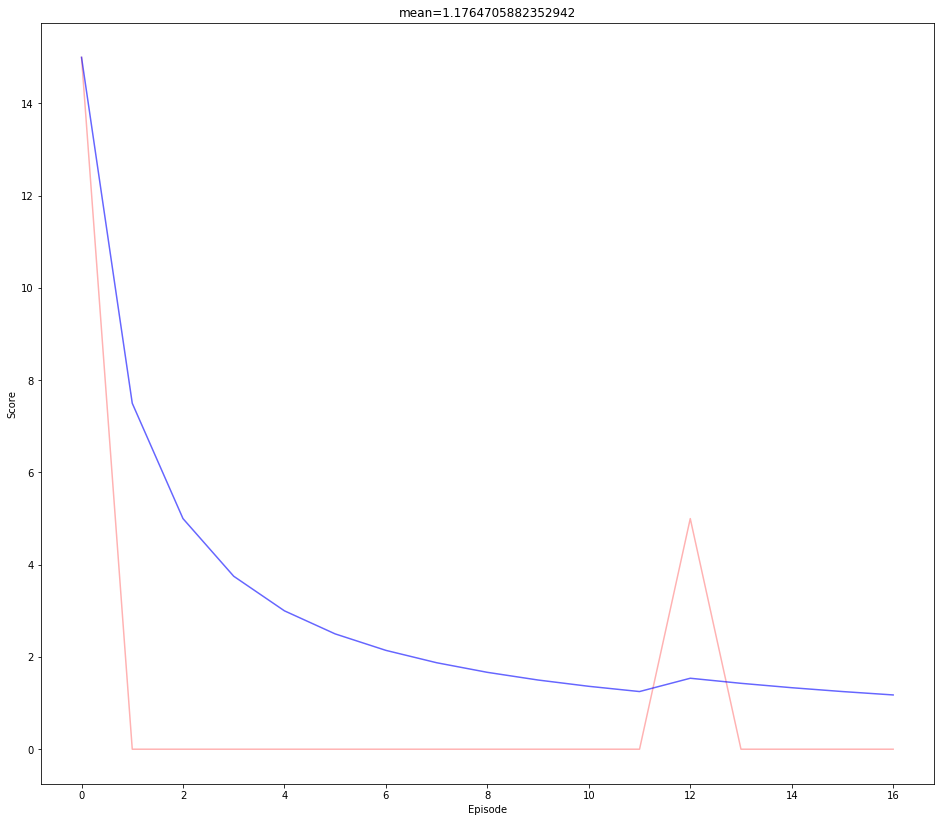

In [7]:
plt.figure(figsize=(16,14))

plt.title("mean={}".format(np.mean(scores)))
plt.plot(scores,'r-', alpha=.3)
plt.plot(mean_score,'b-', alpha=.6)

plt.xlabel("Episode")
plt.ylabel("Score")
plt.show()